# SOPHY Database
### Southern Ocean Phytoplankton Database
- Made by Ayush Nag and Hannah-Joy Warren (add others)
- UW Oceanography (add other credits)

# Environment and package setup
Create new environment
- Miniconda is recommended
```conda create -n sophyvenv geopandas cartopy jupyter pyworms seaborn tqdm```
- TODO: add docker whl option to install packages directly from sophy github

# Import packages

In [1]:
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import mplleaflet
import shapely
import cartopy
import pandas as pd
from pandas import DataFrame
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import numpy as np
import geolabel
import geopandas as gpd
import pyproj
from shapely.ops import transform
from matplotlib.colors import ListedColormap
import matplotlib.path as mpath

# Initialization script
- Builds SOPHY database
- Outputs sophy.db file in virtual environment
- Should be run ONLY once

TODO: this will be __init__.py in package

In [2]:
%run -i sophy.py

Building the SOPHY database


  0%|          | 0/100 [00:00<?, ?it/s]

SOPHY build successful!


# Query the SOPHY Database.
- Queries can be formatted using sophysql.query()
- Output is a pandas DataFrame
- General template and sample queries are provided below

In [3]:
# tables = [sample, occurrence, taxonomy, microscopy]
data: DataFrame = sophy.query("select latitude, longitude from sample UNION ALL select latitude, longitude from occurrence;")
data
# data.to_csv("sample1.csv", index=False)

SOPHY SQL: 0.2143 seconds


,latitude,longitude
0,-64.83333,-64.05167
1,-64.83333,-64.05167
2,-64.83333,-64.05167
3,-64.83333,-64.05167
4,-64.83333,-64.05167
...,...,...
68050,-57.0,170.00000
68051,-57.0,170.00000
68052,-57.0,170.00000
68053,-57.0,170.00000


In [3]:
pd.read_csv('sample1.csv')

,id,source_name,latitude,longitude,timestamp,front_zone,sector,depth,pressure,salinity,...,diss_inorg_nitrogen,diss_inorg_phosp,diss_org_carbon,diss_org_nitrogen,part_org_carbon,part_org_nitrogen,tot_nitrogen,tot_part_carbon,tot_phosp,ph
0,1,lter,-64.83333,-64.05167,1991-11-07 00:36:00,SIZ,BA,2.14998,NaN,33.791000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,lter,-64.83333,-64.05167,1991-11-07 00:36:00,SIZ,BA,10.48500,NaN,33.798000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,lter,-64.83333,-64.05167,1991-11-07 00:36:00,SIZ,BA,20.44900,NaN,33.820000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,lter,-64.83333,-64.05167,1991-11-07 00:36:00,SIZ,BA,30.60000,NaN,33.846000,...,NaN,NaN,NaN,NaN,123.16,NaN,17.00,NaN,NaN,NaN
4,5,lter,-64.83333,-64.05167,1991-11-07 00:36:00,SIZ,BA,40.54660,NaN,33.879000,...,NaN,NaN,NaN,NaN,124.52,NaN,12.28,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29727,29728,joyw,-65.85000,-71.37530,2015-07-04 00:00:00,SIZ,BA,9.90000,10.098500,33.805200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.066667,NaN
29728,29729,joyw,-65.85000,-71.37530,2015-07-05 00:00:00,SIZ,BA,99.20000,100.208000,34.363800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29729,29730,joyw,-65.85000,-71.37530,2015-07-06 00:00:00,SIZ,BA,1.30000,1.291000,33.802200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070000,NaN
29730,29731,joyw,-65.85000,-71.37530,2015-07-07 00:00:00,SIZ,BA,48.80000,49.434167,33.945317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Entries in sample grouped by month and year
data = sophysql.query("select count(*) as entries, strftime('%Y-%m', timestamp) as year_month from sample group by year_month;")
data.to_csv('sample2.csv', index=False)

SOPHY SQL: 0.09482 seconds


In [11]:
# sectors: ['Ross', 'BA', 'Weddell', 'Indian', 'WPO']
data = sophysql.query("select * from sample where sample.percent_diatom > 0.8 and sample.sector == 'BA';")
data

SOPHY SQL: 0.0623 seconds


,id,source_name,cruise,latitude,longitude,timestamp,front_zone,sector,percent_phaeo,percent_diatom,...,chl_a,salinity,temperature,mld,par,nitrate,nitrite,phosphate,silicate,extra_json
0,178,lter,PD91-09,-64.93333,-64.46667,1991-11-11 19:27:00,SIZ,BA,0.000000,0.906201,...,0.1870,33.8400,-1.6479,None,None,27.200,0.000,2.400,43.200,"{""Alloxanthin"":0.0,""BetaCarotene"":0.0,""BottleN..."
1,1069,lter,PD93-01,-64.08735,-66.55957,1993-01-11 23:30:00,SIZ,BA,0.000000,1.000000,...,NaN,33.8560,1.3376,None,None,NaN,NaN,NaN,NaN,"{""Alloxanthin"":0.0,""BetaCarotene"":0.0,""BottleN..."
2,4255,lter,NBP93-02,-66.25417,-67.34000,1993-04-17 05:03:00,SIZ,BA,0.105354,0.815943,...,0.8994,34.1180,-0.5270,None,None,NaN,0.080,2.169,80.890,"{""Alloxanthin"":0.0,""BetaCarotene"":0.0,""BottleN..."
3,4330,lter,NBP93-02,-65.75100,-68.58733,1993-04-18 03:30:00,SIZ,BA,0.167510,0.804148,...,0.0045,34.0150,-1.1278,None,None,NaN,0.167,2.171,74.920,"{""Alloxanthin"":0.0,""BetaCarotene"":0.0,""BottleN..."
4,6987,lter,PD94-01,-66.53872,-67.40968,1994-01-29 19:46:00,SIZ,BA,0.000000,0.980734,...,0.0332,34.1550,-0.2490,None,None,NaN,0.900,NaN,33.700,"{""Alloxanthin"":0.0,""BetaCarotene"":0.0,""BottleN..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,28970,lter,LMG20-01,-65.87762,-68.28263,2020-01-13 14:50:00,SIZ,BA,0.000703,0.956421,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,"{""Alloxanthin"":0.0,""AlphaCarotene"":0.0,""Anther..."
1128,29031,lter,LMG20-01,-67.11498,-71.53319,2020-01-20 11:53:00,SIZ,BA,0.008699,0.937398,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,"{""Alloxanthin"":0.0,""AlphaCarotene"":0.0,""Anther..."
1129,29108,lter,LMG20-01,-66.51472,-69.90954,2020-01-31 22:30:00,SIZ,BA,0.021937,0.804452,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,"{""Alloxanthin"":0.009320282,""AlphaCarotene"":0.0..."
1130,29260,lter,LMG07-01,-63.58978,-67.73552,2007-01-12 12:49:00,ASZ,BA,0.137496,0.813156,...,0.4650,33.7595,2.3437,None,None,20.907,0.229,1.330,4.472,"{""Alkalinity1"":2287.2,""Alkalinity2"":2284.8,""Al..."


In [7]:
# zones: ['STZ', 'SAZ', 'PFZ', 'ASZ', 'SOZ', 'SIZ']
data = sophysql.query("select * from sample where sample.sector == 'Ross';")
data

SOPHY SQL: 0.0281 seconds


,id,source_name,cruise,latitude,longitude,timestamp,front_zone,sector,percent_phaeo,percent_diatom,...,chl_a,salinity,temperature,mld,par,nitrate,nitrite,phosphate,silicate,extra_json


In [13]:
data = sophysql.query("select * from sample where sample.category_silicoflagellate is not null;")
data

SOPHY SQL: 0.0333 seconds


,id,source_name,cruise,latitude,longitude,timestamp,front_zone,sector,depth,pressure,...,diss_inorg_nitrogen,diss_inorg_phosp,diss_org_carbon,diss_org_nitrogen,part_org_carbon,part_org_nitrogen,tot_nitrogen,tot_part_carbon,tot_phosp,ph
0,29516,joyw,None,-64.4192,-65.7108,2014-11-02 00:00:00,SIZ,BA,9.9,9.986889,...,None,None,None,None,None,None,None,None,0.063333,None
1,29582,joyw,None,-65.4067,-75.1285,2014-11-08 00:00:00,ASZ,BA,10.2,10.210875,...,None,None,None,None,None,None,None,None,0.060000,None
2,29599,joyw,None,-66.0910,-73.7510,2014-11-09 00:00:00,SIZ,BA,25.4,25.434375,...,None,None,None,None,None,None,None,None,0.063333,None
3,29605,joyw,None,-66.4393,-73.0173,2014-11-10 00:00:00,SIZ,BA,10.0,10.048875,...,None,None,None,None,None,None,None,None,0.040000,None
4,29612,joyw,None,-66.9475,-71.8985,2014-11-11 00:00:00,SIZ,BA,1.8,1.837000,...,None,None,None,None,None,None,None,None,0.085000,None
5,29624,joyw,None,-66.5160,-71.5918,2014-11-12 00:00:00,SIZ,BA,9.7,9.813000,...,None,None,None,None,None,None,None,None,0.063333,None
6,29631,joyw,None,-66.1003,-70.8532,2014-11-13 00:00:00,SIZ,BA,9.9,10.051625,...,None,None,None,None,None,None,None,None,NaN,None
7,29679,joyw,None,-65.4100,-69.2895,2014-11-17 00:00:00,SIZ,BA,25.2,25.517100,...,None,None,None,None,None,None,None,None,0.060000,None
8,29689,joyw,None,-64.7518,-70.8567,2014-11-18 00:00:00,SIZ,BA,10.0,9.700125,...,None,None,None,None,None,None,None,None,0.066667,None
9,29708,joyw,None,-64.4972,-74.1772,2014-11-19 00:00:00,ASZ,BA,9.9,10.265714,...,None,None,None,None,None,None,None,None,0.070000,None


In [2]:
data = sophysql.query("select * from sample;")
data

SOPHY SQL: 1.68957 seconds


,id,source_name,latitude,longitude,timestamp,front_zone,sector,depth,pressure,salinity,...,diss_inorg_nitrogen,diss_inorg_phosp,diss_org_carbon,diss_org_nitrogen,part_org_carbon,part_org_nitrogen,tot_nitrogen,tot_part_carbon,tot_phosp,ph
0,1,lter,-64.83333,-64.05167,1991-11-07 00:36:00,SIZ,BA,2.14998,NaN,33.791000,...,None,None,NaN,None,NaN,None,NaN,None,NaN,None
1,2,lter,-64.83333,-64.05167,1991-11-07 00:36:00,SIZ,BA,10.48500,NaN,33.798000,...,None,None,NaN,None,NaN,None,NaN,None,NaN,None
2,3,lter,-64.83333,-64.05167,1991-11-07 00:36:00,SIZ,BA,20.44900,NaN,33.820000,...,None,None,NaN,None,NaN,None,NaN,None,NaN,None
3,4,lter,-64.83333,-64.05167,1991-11-07 00:36:00,SIZ,BA,30.60000,NaN,33.846000,...,None,None,NaN,None,123.16,None,17.00,None,NaN,None
4,5,lter,-64.83333,-64.05167,1991-11-07 00:36:00,SIZ,BA,40.54660,NaN,33.879000,...,None,None,NaN,None,124.52,None,12.28,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29727,29728,joyw,-65.85000,-71.37530,2015-07-04 00:00:00,SIZ,BA,9.90000,10.098500,33.805200,...,None,None,NaN,None,NaN,None,NaN,None,0.066667,None
29728,29729,joyw,-65.85000,-71.37530,2015-07-05 00:00:00,SIZ,BA,99.20000,100.208000,34.363800,...,None,None,NaN,None,NaN,None,NaN,None,NaN,None
29729,29730,joyw,-65.85000,-71.37530,2015-07-06 00:00:00,SIZ,BA,1.30000,1.291000,33.802200,...,None,None,NaN,None,NaN,None,NaN,None,0.070000,None
29730,29731,joyw,-65.85000,-71.37530,2015-07-07 00:00:00,SIZ,BA,48.80000,49.434167,33.945317,...,None,None,NaN,None,NaN,None,NaN,None,NaN,None


In [ ]:
# ADD get all from sample but limit 20; easier to see all the datasets and the available data

In [ ]:
# add other sample queries
# TODO: Make SQL Views for commonly used queries
# - filter by front and sector
# - filter by year range
# - view only a certain month over time

# Plot setup

In [5]:
def so_map_ax() -> plt.axes:
    map_proj = ccrs.SouthPolarStereo()
    fig = plt.figure(figsize=[12, 12])  # inches
    ax = plt.subplot(projection=map_proj)
    ax.set_extent([-180, 180, -90, -39.4], ccrs.PlateCarree())
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)
    ax.add_feature(cartopy.feature.LAND)
    ax.gridlines(xlocs=[-130, -60, 20, 90, 160], draw_labels=True)
    theta  = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5  ## could use 0.45 here, as Simon Thomas did
    verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)
    return ax

def make_sectors() -> gpd.GeoDataFrame:
    project = pyproj.Transformer.from_crs(ccrs.PlateCarree(), ccrs.SouthPolarStereo(), always_xy=True).transform
    s1 = transform(project, Polygon(zip(np.append(np.linspace(start=-130, stop=-60, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s2 = transform(project, Polygon(zip(np.append(np.linspace(start=-60, stop=20, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s3 = transform(project, Polygon(zip(np.append(np.linspace(start=20, stop=90, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s4 = transform(project, Polygon(zip(np.append(np.linspace(start=90, stop=160, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s5 = transform(project, Polygon(zip(np.append(np.append(np.linspace(start=160, stop=180, num=500), np.linspace(start=-180, stop=-130, num=500)), 0), np.append(np.full(1000, -30), -90))))
    s: list = [s1, s2, s3, s4, s5]
    sectors = gpd.GeoDataFrame(geometry=s, crs=ccrs.SouthPolarStereo())
    return sectors

def my_map() -> ListedColormap:
        # Color shades
    greens  = ['#659222', '#7EA640', '#97BB5E', '#AFCF7D', '#C8E49B', '#E1F8B9']
    yellows = ['#B37707', '#CC8E1B', '#E6A52E', '#FFBC42', '#FFCE75', '#FDE3B1']
    maroons = ['#8F2D56', '#A24C70', '#B66A8B', '#C989A5', '#DDA7C0', '#F0C6DA']
    purples = ['#503E8F', '#6E5EA3', '#8B7FB7', '#A99FCA', '#C6C0DE', '#E4E0F2']
    teals   = ['#218380', '#459B99', '#69B2B3', '#8DCACC', '#B1E1E6', '#D5F9FF']
    greens.reverse(), yellows.reverse(), maroons.reverse(), purples.reverse(), teals.reverse()
    # List of all colors
    color_palette = greens + yellows + maroons + purples + teals
    # Make color palette
    colors = ListedColormap(sns.color_palette(color_palette).as_hex())
    return colors

# Plot query on Southern Ocean
- Includes zones and sectors
- Modify the data variable (DataFrame) with queries above and plot here

<GeoAxesSubplot: >

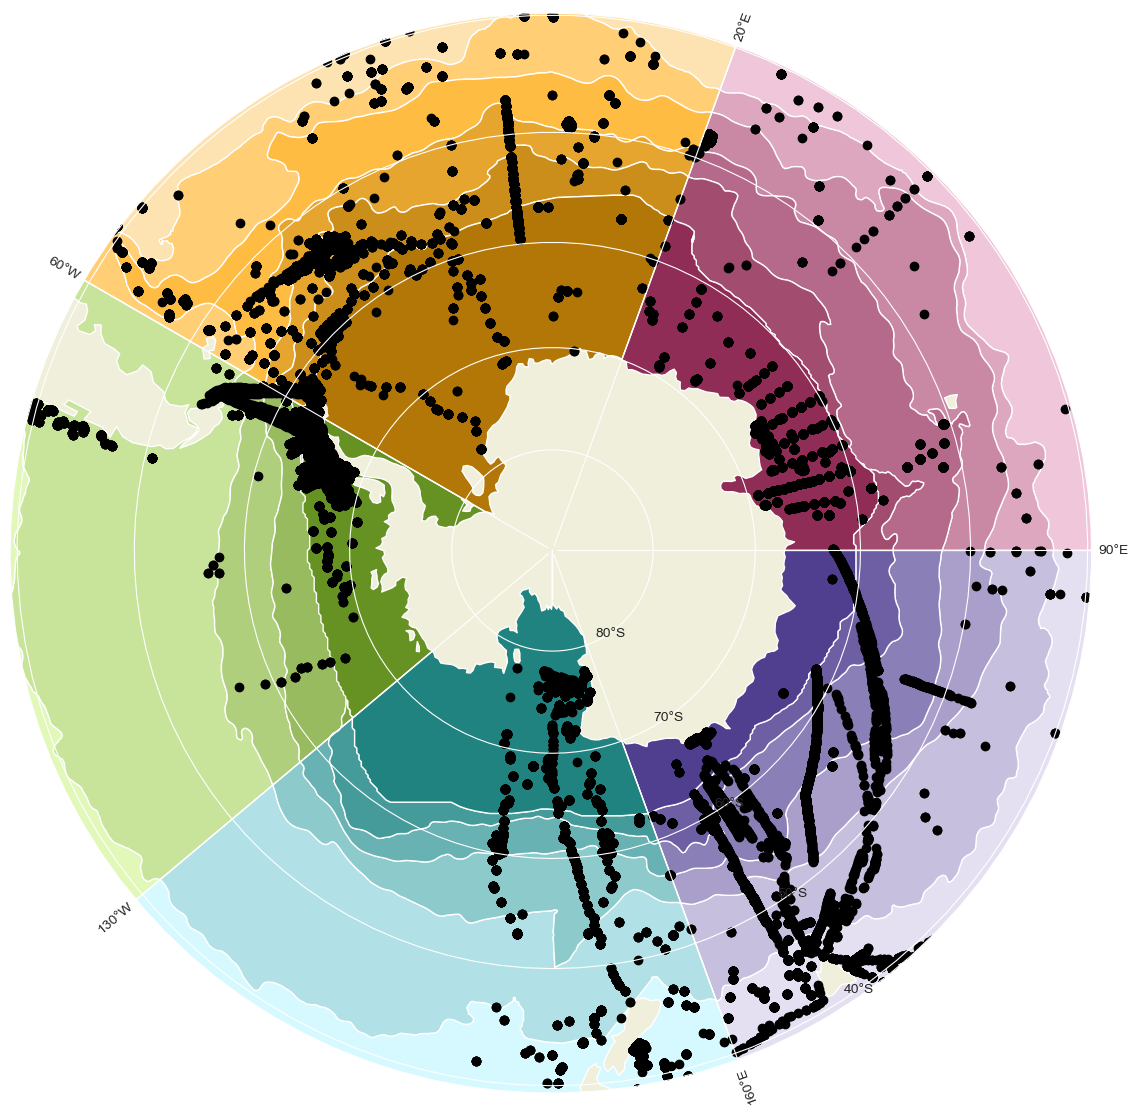

In [6]:
# Generate Southern Ocean plot, GeoDataFrame of sectors, and colormap
ax, sectors, colormap = so_map_ax(), make_sectors(), my_map()
# Get Southern Ocean zones as GeoDataFrame (with shapefiles)
zones: gpd.GeoDataFrame = gpd.read_file(geolabel.zones_shapefile).to_crs(crs=ccrs.SouthPolarStereo())
# Overlay zones and sectors
res = zones.overlay(sectors, how='intersection', keep_geom_type=True)
# res.explore(cmap=colormap, tooltip=True)
res.plot(ax=ax, cmap=colormap, edgecolor='w', legend=True)
# mplleaflet.show()
# Plot queried data
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=ccrs.PlateCarree())
data_gdf.to_crs(crs=ccrs.SouthPolarStereo(), inplace=True)
data_gdf.plot(ax=ax, color='k')

In [16]:
# color by type of data, data source, year, season
#   - option in plotting function
# update gridline labels to align with sectors
# red=chemtax, blue=micro, purple=both

# show by type of data available

# filter down area
# Two scatter plots for chemtax and microscopy vs. time
#   - sort by time to draw line
#   - try chemtax one first; test all chemtax, otherwise do phaeo, diatoms, other
# zoom to fit data (with padding for visibility)

In [1]:
%run -i sophy.py

Building the SOPHY database


  0%|          | 0/100 [00:00<?, ?it/s]

SOPHY build successful!


``` conda install -c conda-forge datasette```
Change directory to sophy/sophy
``` datasette sophy.db -o```

In [ ]:
# main features are phaeo, diatoms, other